# Enummerate amides

Generate library of amides by enumerate amines from enamine against the acid we are interested in.

In [19]:
from typing import Union
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdchem import Mol


def ensure_is_mol_object(smi_or_mol: Union[str, Mol],) -> Chem.Mol:
    if isinstance(smi_or_mol, str):
        definitely_a_mol = Chem.MolFromSmiles(smi_or_mol)
    elif isinstance(smi_or_mol, Mol):
        definitely_a_mol = smi_or_mol
    else:
        raise ValueError(
            f'{smi_or_mol} is not an RDKit Mol object!')    
    return definitely_a_mol
    
def peptide_coupling_rxn() -> rdChemReactions.ChemicalReaction:

    acid_smarts = '[*:1][C:2](=O)O'
    amine_smarts = '[NX3;!$(N*=*):3]([H:4])[*:5]'
    amide_smarts = '[*:1][C:2](=O)[N:3][*:5]'

    peptide_rxn_smarts = f'{acid_smarts}.{amine_smarts}>>{amide_smarts}'
    peptide_rxn = rdChemReactions.ReactionFromSmarts(
        peptide_rxn_smarts)

    return peptide_rxn


def run_peptide_coupling(acid: Union[str, Mol],
                         amine: Union[str, Mol],
                         peptide_rxn: rdChemReactions.ChemicalReaction = None) -> Chem.Mol:
    
    acid = ensure_is_mol_object(acid)
    amine = ensure_is_mol_object(amine)
    
    reactants = tuple([Chem.AddHs(acid), Chem.AddHs(amine)])

    if peptide_rxn is None:
        peptide_rxn = peptide_coupling_rxn()

    possible_products = peptide_rxn.RunReactants(reactants)
    if len(possible_products) == 0:
            logging.warning(
                f'No product produced')
            return None
    else:
        product = Chem.RemoveHs(possible_products[0][0])
        return Chem.MolToSmiles(product)

Let's test with a simple case

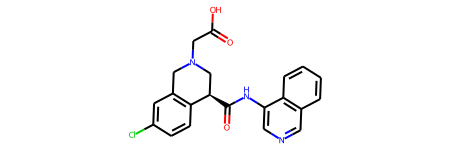

In [17]:
acid = 'Clc1cc2c([C@H](C(Nc(cnc3)c4c3cccc4)=O)CN(CC(=O)O)C2)cc1'
acid = Chem.MolFromSmiles(acid)

acid

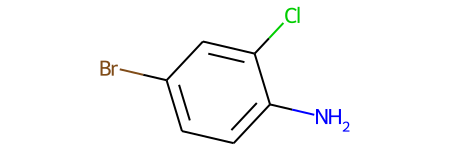

In [11]:
amine = 'Nc1ccc(Br)cc1Cl'
amine = Chem.MolFromSmiles(amine)

amine


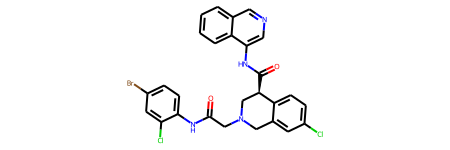

In [21]:
Chem.MolFromSmiles(run_peptide_coupling(acid, amine))

Now let's enumerate with the enamine amines

In [22]:
from tqdm import tqdm
import pandas as pd

df_amines = pd.read_csv(
    '../data/enamine_primary_and_secondary_amines.csv')

peptide_rxn = peptide_coupling_rxn()

for index, row in tqdm(df_amines.iterrows(), total=len(df_amines)):
    df_amines.loc[index, 'amide'] = run_peptide_coupling(acid, row.SMILES, peptide_rxn)

7261it [00:20, 323.12it/s]WARNING:root:No product produced
26965it [01:15, 295.05it/s]WARNING:root:No product produced
62813it [03:04, 340.72it/s]


In [25]:
print(f'Original length of df_amines = {len(df_amines)}')
print(f'Length of df_amines after removing NaNs = {len(df_amines.dropna())}')
print(f'Length of df_amines after removing NaNs & duplicates= {len(df_amines.dropna().drop_duplicates("amide"))}')


Original length of df_amines = 62813
Length of df_amines after removing NaNs = 62811
Length of df_amines after removing NaNs & duplicates= 58412


In [27]:
df_amines.to_csv('../data/processed/enumerated_amides.csv', index=False)
